In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
with open('DataSplit.pickle', 'rb') as handle:
    DataSplit = pickle.load(handle)

In [3]:
# Hyperparameters
train_batch_size = 10
val_batch_size = 10
learning_rate = 0.0001
num_epochs = 200

In [4]:
class Senz3DDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels
        self.GT_labels = {'1': 5, '2': 2, '3': 3, '4': 5, '5': 0, '6': 2, 
                          '7': 1, '8': 4, '9': 3, '10': 1, '11': 1}
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img = cv2.imread("..\\." + self.paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img.shape[1]//4, img.shape[0]//4)).astype(np.uint8)
        
        label = torch.tensor(self.GT_labels[(self.labels[idx])])
        
        return {'img': img, 'label': label}

In [5]:
# Make Datasets
TrainDataset = Senz3DDataset(list(DataSplit['train'].keys()), list(DataSplit['train'].values()))
ValDataset = Senz3DDataset(list(DataSplit['val'].keys()), list(DataSplit['val'].values()))
TestDataset = Senz3DDataset(list(DataSplit['test'].keys()), list(DataSplit['test'].values()))

In [6]:
#  Make DataLoaders
TrainDataLoader = DataLoader(TrainDataset, batch_size=train_batch_size, shuffle=True)
ValDataLoader = DataLoader(ValDataset, batch_size=val_batch_size, shuffle=True)
TestDataLoader = DataLoader(TestDataset, batch_size=1, shuffle=False)

In [10]:
import torchvision.models as models
model_name = 'resnet152'
model = models.resnet152(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1024, bias=True),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 64),
    nn.ReLU(),
    nn.Linear(64,6),
    nn.Softmax(dim=1),    
    )

for i, param in enumerate(model.parameters()):
    if i < 465:
      print(f'Layer{i} frozen:', type(param), param.size())
      param.requires_grad = False
    else: 
      print(f'Layer{i} not frozen', type(param), param.size())
      param.requires_grad = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_metric = nn.CrossEntropyLoss()

Layer0 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64, 3, 7, 7])
Layer1 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer2 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer3 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 1, 1])
Layer4 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer5 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer6 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3])
Layer7 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer8 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer9 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([256, 64, 1, 1])
Layer10 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([256])
Layer11 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([256])
Layer12 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([256, 64, 1, 1])
Layer13 frozen: <clas

In [11]:
# Initialize
epoch_train_loss = []
epoch_train_accuracy = []

epoch_val_loss = []
epoch_val_accuracy = []

epoch_test_loss = []
epoch_test_accuracy = []

best_val_accuracy = 0

for epic in range(num_epochs):
    
    # Put model in training mode
    model.train()
    
    train_correct = 0
    train_total = 0
    train_loss = 0
    
    for i, sample in tqdm.tqdm(enumerate(TrainDataLoader)):
        
        # move inputs to device
        if torch.cuda.is_available():
            x = sample['img'].permute(0, 3, 1, 2).float().to(device)
            y = sample['label'].to(device)
        
        # Loop over model, calculate loss
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_metric(output, y)
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy/loss
        _, y_hat = torch.max(output, dim=1)
        
        train_correct += torch.sum(y_hat == y)
        train_total += x.shape[0]
        train_loss += loss.item() * x.shape[0]
        
    # Append to epoch loss/accuracy
    epoch_train_loss.append(train_loss / train_total)
    epoch_train_accuracy.append(train_correct.float() / train_total)
    
    print(f'Epoch: {epic}, Train Loss: {epoch_train_loss[-1]}, Train Acc: {epoch_train_accuracy[-1]}')
    
    # Put model in validation mode
    model.eval()
    
    val_total = 0
    val_correct = 0
    val_loss = 0
    
    with torch.no_grad():
        for i, sample in enumerate(ValDataLoader):
            
            # move inputs to device
            if torch.cuda.is_available():
                x = sample['img'].permute(0, 3, 1, 2).float().to(device)
                y = sample['label'].to(device)

            output = model.forward(x)
            loss = loss_metric(output, y)
            
            # Calculate accuracy/loss
            _, y_hat = torch.max(output, dim=1)
            batch_correct = torch.sum(y_hat == y)
            val_correct += torch.sum(y_hat == y)
            val_total += x.shape[0]
            val_loss += loss.item() * x.shape[0]
            
    # Append to epoch loss/accuracy
    epoch_val_loss.append(val_loss / val_total)
    val_accuracy = val_correct.float() / val_total
    epoch_val_accuracy.append(val_accuracy)
    
    if val_accuracy > best_val_accuracy:
        print("Saved new best model.")
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), f'saved_models/{model_name}.pth')
    
    print(f'Epoch: {epic}, Val Loss: {epoch_val_loss[-1]}, Val Acc: {epoch_val_accuracy[-1]}')
    
    

97it [00:19,  5.00it/s]


Epoch: 0, Train Loss: 1.7583111752354592, Train Acc: 0.46936658024787903
Saved new best model.


0it [00:00, ?it/s]

Epoch: 0, Val Loss: 1.6741409576196464, Val Acc: 0.597122311592102


97it [00:19,  5.03it/s]


Epoch: 1, Train Loss: 1.6266779841416104, Train Acc: 0.5430945158004761
Saved new best model.


0it [00:00, ?it/s]

Epoch: 1, Val Loss: 1.5480599128942696, Val Acc: 0.6402877569198608


97it [00:19,  5.04it/s]


Epoch: 2, Train Loss: 1.554390883148645, Train Acc: 0.6085150837898254
Saved new best model.


0it [00:00, ?it/s]

Epoch: 2, Val Loss: 1.4920891008788733, Val Acc: 0.7050359845161438


97it [00:19,  4.95it/s]


Epoch: 3, Train Loss: 1.4970310654100476, Train Acc: 0.672897219657898


0it [00:00, ?it/s]

Epoch: 3, Val Loss: 1.519898502089137, Val Acc: 0.5827338099479675


97it [00:19,  4.97it/s]


Epoch: 4, Train Loss: 1.4889621349633793, Train Acc: 0.6853582859039307


0it [00:00, ?it/s]

Epoch: 4, Val Loss: 1.498835790071556, Val Acc: 0.6115108132362366


97it [00:18,  5.13it/s]


Epoch: 5, Train Loss: 1.472811486119422, Train Acc: 0.7030114531517029


0it [00:00, ?it/s]

Epoch: 5, Val Loss: 1.4849164648879347, Val Acc: 0.6978417634963989


97it [00:19,  5.08it/s]


Epoch: 6, Train Loss: 1.481605311296687, Train Acc: 0.6770508885383606


0it [00:00, ?it/s]

Epoch: 6, Val Loss: 1.4920564135201544, Val Acc: 0.6402877569198608


97it [00:18,  5.17it/s]


Epoch: 7, Train Loss: 1.4772090697709397, Train Acc: 0.6884735226631165


0it [00:00, ?it/s]

Epoch: 7, Val Loss: 1.5039921467252773, Val Acc: 0.5827338099479675


97it [00:18,  5.17it/s]


Epoch: 8, Train Loss: 1.4737261193316054, Train Acc: 0.701973021030426


0it [00:00, ?it/s]

Epoch: 8, Val Loss: 1.4910994759566492, Val Acc: 0.6834532618522644


97it [00:19,  5.03it/s]


Epoch: 9, Train Loss: 1.4811637155239703, Train Acc: 0.6791277527809143


0it [00:00, ?it/s]

Epoch: 9, Val Loss: 1.4820217537365372, Val Acc: 0.6834532618522644


97it [00:19,  4.93it/s]


Epoch: 10, Train Loss: 1.4592823926533494, Train Acc: 0.7196261882781982


0it [00:00, ?it/s]

Epoch: 10, Val Loss: 1.4828710401658531, Val Acc: 0.6978417634963989


97it [00:19,  4.99it/s]


Epoch: 11, Train Loss: 1.4787360640205947, Train Acc: 0.672897219657898


0it [00:00, ?it/s]

Epoch: 11, Val Loss: 1.4832822667609016, Val Acc: 0.6762589812278748


97it [00:19,  4.91it/s]


Epoch: 12, Train Loss: 1.476526364730526, Train Acc: 0.7050883173942566


0it [00:00, ?it/s]

Epoch: 12, Val Loss: 1.5007249459945897, Val Acc: 0.6187050342559814


97it [00:19,  5.00it/s]


Epoch: 13, Train Loss: 1.4715409549968637, Train Acc: 0.6884735226631165


0it [00:00, ?it/s]

Epoch: 13, Val Loss: 1.473933931734922, Val Acc: 0.6978417634963989


97it [00:19,  4.99it/s]


Epoch: 14, Train Loss: 1.4683272941337815, Train Acc: 0.6718587875366211


0it [00:00, ?it/s]

Epoch: 14, Val Loss: 1.4682156267783624, Val Acc: 0.6762589812278748


97it [00:19,  4.98it/s]


Epoch: 15, Train Loss: 1.4708468380499233, Train Acc: 0.7102804183959961


0it [00:00, ?it/s]

Epoch: 15, Val Loss: 1.4705696654834335, Val Acc: 0.6834532618522644


97it [00:19,  4.98it/s]


Epoch: 16, Train Loss: 1.4642558976744813, Train Acc: 0.7133956551551819


0it [00:00, ?it/s]

Epoch: 16, Val Loss: 1.4796805853466335, Val Acc: 0.633093535900116


97it [00:19,  4.93it/s]


Epoch: 17, Train Loss: 1.4676594267505476, Train Acc: 0.7144340872764587


0it [00:00, ?it/s]

Epoch: 17, Val Loss: 1.4978881156701835, Val Acc: 0.597122311592102


97it [00:20,  4.68it/s]


Epoch: 18, Train Loss: 1.4583773556032904, Train Acc: 0.7092419862747192


0it [00:00, ?it/s]

Epoch: 18, Val Loss: 1.4683839194208599, Val Acc: 0.6690647602081299


97it [00:19,  4.97it/s]


Epoch: 19, Train Loss: 1.456053833228653, Train Acc: 0.7227414846420288


0it [00:00, ?it/s]

Epoch: 19, Val Loss: 1.4701566095832441, Val Acc: 0.6906474828720093


97it [00:19,  4.89it/s]


Epoch: 20, Train Loss: 1.4537220037119658, Train Acc: 0.7497404217720032
Saved new best model.


0it [00:00, ?it/s]

Epoch: 20, Val Loss: 1.4491928678622348, Val Acc: 0.7266187071800232


97it [00:20,  4.78it/s]


Epoch: 21, Train Loss: 1.4587895055673823, Train Acc: 0.7279335856437683


0it [00:00, ?it/s]

Epoch: 21, Val Loss: 1.46510928397556, Val Acc: 0.7266187071800232


97it [00:19,  4.86it/s]


Epoch: 22, Train Loss: 1.4627153124517123, Train Acc: 0.7372793555259705


0it [00:00, ?it/s]

Epoch: 22, Val Loss: 1.4622245520996533, Val Acc: 0.6258993148803711


97it [00:20,  4.84it/s]


Epoch: 23, Train Loss: 1.4627482300606844, Train Acc: 0.712357223033905


0it [00:00, ?it/s]

Epoch: 23, Val Loss: 1.4870355403680595, Val Acc: 0.7050359845161438


97it [00:19,  4.97it/s]


Epoch: 24, Train Loss: 1.4616846190310961, Train Acc: 0.7061266899108887


0it [00:00, ?it/s]

Epoch: 24, Val Loss: 1.46914252274328, Val Acc: 0.6690647602081299


97it [00:19,  4.96it/s]


Epoch: 25, Train Loss: 1.4516819358986115, Train Acc: 0.7227414846420288


0it [00:00, ?it/s]

Epoch: 25, Val Loss: 1.4919190415375525, Val Acc: 0.6474820375442505


97it [00:19,  4.99it/s]


Epoch: 26, Train Loss: 1.4668455409855115, Train Acc: 0.7352025508880615


0it [00:00, ?it/s]

Epoch: 26, Val Loss: 1.4470371290934172, Val Acc: 0.7194244861602783


97it [00:18,  5.11it/s]


Epoch: 27, Train Loss: 1.4624363773213245, Train Acc: 0.7175493836402893


0it [00:00, ?it/s]

Epoch: 27, Val Loss: 1.4580253379808055, Val Acc: 0.6402877569198608


97it [00:19,  5.09it/s]


Epoch: 28, Train Loss: 1.45056388558876, Train Acc: 0.7383177876472473


0it [00:00, ?it/s]

Epoch: 28, Val Loss: 1.4630473543414109, Val Acc: 0.6762589812278748


97it [00:19,  4.91it/s]


Epoch: 29, Train Loss: 1.4627230345645799, Train Acc: 0.7196261882781982


0it [00:00, ?it/s]

Epoch: 29, Val Loss: 1.4858766099531873, Val Acc: 0.6690647602081299


97it [00:20,  4.85it/s]


Epoch: 30, Train Loss: 1.455833229320443, Train Acc: 0.7435098886489868


0it [00:00, ?it/s]

Epoch: 30, Val Loss: 1.4839277507589876, Val Acc: 0.6906474828720093


97it [00:20,  4.77it/s]


Epoch: 31, Train Loss: 1.4468710172461077, Train Acc: 0.761163055896759
Saved new best model.


1it [00:00,  5.18it/s]

Epoch: 31, Val Loss: 1.457468393037645, Val Acc: 0.7410072088241577


97it [00:20,  4.84it/s]


Epoch: 32, Train Loss: 1.4551767515616254, Train Acc: 0.7455867528915405


0it [00:00, ?it/s]

Epoch: 32, Val Loss: 1.4682286454619264, Val Acc: 0.6834532618522644


97it [00:20,  4.74it/s]


Epoch: 33, Train Loss: 1.458910791425814, Train Acc: 0.74247145652771


0it [00:00, ?it/s]

Epoch: 33, Val Loss: 1.449093533934449, Val Acc: 0.7194244861602783


97it [00:20,  4.81it/s]


Epoch: 34, Train Loss: 1.449934548801846, Train Acc: 0.75077885389328


0it [00:00, ?it/s]

Epoch: 34, Val Loss: 1.474890542544907, Val Acc: 0.661870539188385


97it [00:19,  4.86it/s]


Epoch: 35, Train Loss: 1.4463065710394554, Train Acc: 0.7455867528915405


0it [00:00, ?it/s]

Epoch: 35, Val Loss: 1.4735253706252833, Val Acc: 0.6762589812278748


97it [00:19,  5.00it/s]


Epoch: 36, Train Loss: 1.4525040017976691, Train Acc: 0.7538940906524658


0it [00:00, ?it/s]

Epoch: 36, Val Loss: 1.454254502015148, Val Acc: 0.7410072088241577


97it [00:18,  5.11it/s]


Epoch: 37, Train Loss: 1.4564773543725256, Train Acc: 0.7300103902816772


0it [00:00, ?it/s]

Epoch: 37, Val Loss: 1.4627373664499186, Val Acc: 0.7194244861602783


97it [00:19,  5.08it/s]


Epoch: 38, Train Loss: 1.4528518514098407, Train Acc: 0.7455867528915405


0it [00:00, ?it/s]

Epoch: 38, Val Loss: 1.4728607299516527, Val Acc: 0.6762589812278748


97it [00:18,  5.15it/s]


Epoch: 39, Train Loss: 1.4536339391181525, Train Acc: 0.7684320211410522


0it [00:00, ?it/s]

Epoch: 39, Val Loss: 1.454875755653107, Val Acc: 0.7266187071800232


97it [00:18,  5.11it/s]


Epoch: 40, Train Loss: 1.4556637163102812, Train Acc: 0.7528557181358337


0it [00:00, ?it/s]

Epoch: 40, Val Loss: 1.4576303015509955, Val Acc: 0.7194244861602783


97it [00:18,  5.15it/s]


Epoch: 41, Train Loss: 1.4436176275043349, Train Acc: 0.7788162231445312


0it [00:00, ?it/s]

Epoch: 41, Val Loss: 1.466364739610137, Val Acc: 0.7050359845161438


97it [00:18,  5.15it/s]


Epoch: 42, Train Loss: 1.4478534120884516, Train Acc: 0.7622014880180359


0it [00:00, ?it/s]

Epoch: 42, Val Loss: 1.4480300567132964, Val Acc: 0.7338129878044128


97it [00:18,  5.16it/s]


Epoch: 43, Train Loss: 1.448111448084949, Train Acc: 0.761163055896759


0it [00:00, ?it/s]

Epoch: 43, Val Loss: 1.4397935164060525, Val Acc: 0.7410072088241577


97it [00:18,  5.16it/s]


Epoch: 44, Train Loss: 1.4595271525972233, Train Acc: 0.7258567214012146


0it [00:00, ?it/s]

Epoch: 44, Val Loss: 1.4481091087670634, Val Acc: 0.7266187071800232


97it [00:18,  5.15it/s]


Epoch: 45, Train Loss: 1.4379989067218262, Train Acc: 0.7850467562675476


0it [00:00, ?it/s]

Epoch: 45, Val Loss: 1.486892576697919, Val Acc: 0.7266187071800232


97it [00:19,  5.07it/s]


Epoch: 46, Train Loss: 1.4507003834438226, Train Acc: 0.7414330244064331


0it [00:00, ?it/s]

Epoch: 46, Val Loss: 1.4686794169515156, Val Acc: 0.6978417634963989


97it [00:18,  5.13it/s]


Epoch: 47, Train Loss: 1.4527401515627947, Train Acc: 0.7642783522605896


0it [00:00, ?it/s]

Epoch: 47, Val Loss: 1.494133330077576, Val Acc: 0.6187050342559814


97it [00:18,  5.15it/s]


Epoch: 48, Train Loss: 1.4614569669200623, Train Acc: 0.7341641187667847


0it [00:00, ?it/s]

Epoch: 48, Val Loss: 1.4401169389271908, Val Acc: 0.7338129878044128


97it [00:18,  5.15it/s]


Epoch: 49, Train Loss: 1.4560141659971337, Train Acc: 0.7580478191375732


0it [00:00, ?it/s]

Epoch: 49, Val Loss: 1.4840272219060995, Val Acc: 0.6762589812278748


97it [00:18,  5.15it/s]


Epoch: 50, Train Loss: 1.4442154991044929, Train Acc: 0.7892004251480103


0it [00:00, ?it/s]

Epoch: 50, Val Loss: 1.4603150388319714, Val Acc: 0.7194244861602783


97it [00:18,  5.14it/s]


Epoch: 51, Train Loss: 1.4545714685602475, Train Acc: 0.7466251850128174


0it [00:00, ?it/s]

Epoch: 51, Val Loss: 1.4474662490885892, Val Acc: 0.7266187071800232


97it [00:19,  5.05it/s]


Epoch: 52, Train Loss: 1.4432504700723094, Train Acc: 0.770508885383606


0it [00:00, ?it/s]

Epoch: 52, Val Loss: 1.4717181140570332, Val Acc: 0.7050359845161438


97it [00:18,  5.15it/s]


Epoch: 53, Train Loss: 1.4658851296730873, Train Acc: 0.7300103902816772
Saved new best model.


1it [00:00,  5.26it/s]

Epoch: 53, Val Loss: 1.4445026992893906, Val Acc: 0.7697842121124268


97it [00:19,  5.02it/s]


Epoch: 54, Train Loss: 1.463095564337163, Train Acc: 0.7663551568984985


0it [00:00, ?it/s]

Epoch: 54, Val Loss: 1.4650309900585696, Val Acc: 0.7266187071800232


97it [00:18,  5.14it/s]


Epoch: 55, Train Loss: 1.4540254437168316, Train Acc: 0.770508885383606


0it [00:00, ?it/s]

Epoch: 55, Val Loss: 1.4888931289851237, Val Acc: 0.6762589812278748


97it [00:18,  5.14it/s]


Epoch: 56, Train Loss: 1.439952176184174, Train Acc: 0.8058152198791504


0it [00:00, ?it/s]

Epoch: 56, Val Loss: 1.4657404559979337, Val Acc: 0.7266187071800232


97it [00:18,  5.15it/s]


Epoch: 57, Train Loss: 1.4503477902179691, Train Acc: 0.791277289390564


0it [00:00, ?it/s]

Epoch: 57, Val Loss: 1.4402634119815965, Val Acc: 0.7697842121124268


97it [00:19,  5.05it/s]


Epoch: 58, Train Loss: 1.4497680238226616, Train Acc: 0.7943925857543945


0it [00:00, ?it/s]

Epoch: 58, Val Loss: 1.4790353654957504, Val Acc: 0.7410072088241577


97it [00:18,  5.14it/s]


Epoch: 59, Train Loss: 1.4487523589426359, Train Acc: 0.7892004251480103


0it [00:00, ?it/s]

Epoch: 59, Val Loss: 1.4725700711174834, Val Acc: 0.7410072088241577


97it [00:18,  5.13it/s]


Epoch: 60, Train Loss: 1.4567039360757434, Train Acc: 0.7632399201393127


0it [00:00, ?it/s]

Epoch: 60, Val Loss: 1.452330154480694, Val Acc: 0.7266187071800232


97it [00:18,  5.15it/s]


Epoch: 61, Train Loss: 1.4481937037326342, Train Acc: 0.761163055896759


0it [00:00, ?it/s]

Epoch: 61, Val Loss: 1.4669356912160092, Val Acc: 0.6834532618522644


97it [00:18,  5.15it/s]


Epoch: 62, Train Loss: 1.459392211147558, Train Acc: 0.7528557181358337
Saved new best model.


0it [00:00, ?it/s]

Epoch: 62, Val Loss: 1.4260572743930404, Val Acc: 0.7913669347763062


97it [00:19,  5.03it/s]


Epoch: 63, Train Loss: 1.4563454961479638, Train Acc: 0.7559709548950195


0it [00:00, ?it/s]

Epoch: 63, Val Loss: 1.460456565987292, Val Acc: 0.7769784331321716


97it [00:19,  5.05it/s]


Epoch: 64, Train Loss: 1.4515560068197835, Train Acc: 0.770508885383606


0it [00:00, ?it/s]

Epoch: 64, Val Loss: 1.4532402033428493, Val Acc: 0.7913669347763062


97it [00:18,  5.15it/s]


Epoch: 65, Train Loss: 1.4617110246933633, Train Acc: 0.7352025508880615
Saved new best model.


0it [00:00, ?it/s]

Epoch: 65, Val Loss: 1.4554697583905227, Val Acc: 0.798561155796051


97it [00:19,  5.01it/s]


Epoch: 66, Train Loss: 1.4342356692469627, Train Acc: 0.8110073208808899


0it [00:00, ?it/s]

Epoch: 66, Val Loss: 1.4541302739287452, Val Acc: 0.7913669347763062


97it [00:19,  5.09it/s]


Epoch: 67, Train Loss: 1.4481419284024342, Train Acc: 0.7871236205101013


0it [00:00, ?it/s]

Epoch: 67, Val Loss: 1.4436375228621119, Val Acc: 0.7410072088241577


97it [00:19,  5.04it/s]


Epoch: 68, Train Loss: 1.4473589417347656, Train Acc: 0.8006230592727661


0it [00:00, ?it/s]

Epoch: 68, Val Loss: 1.4403386116027832, Val Acc: 0.7913669347763062


97it [00:18,  5.11it/s]


Epoch: 69, Train Loss: 1.4473608963709879, Train Acc: 0.8058152198791504


0it [00:00, ?it/s]

Epoch: 69, Val Loss: 1.4242600271170087, Val Acc: 0.7553957104682922


97it [00:19,  5.07it/s]


Epoch: 70, Train Loss: 1.449304759192937, Train Acc: 0.7943925857543945


0it [00:00, ?it/s]

Epoch: 70, Val Loss: 1.4865558010211093, Val Acc: 0.6906474828720093


97it [00:18,  5.15it/s]


Epoch: 71, Train Loss: 1.4433818540592926, Train Acc: 0.8110073208808899


0it [00:00, ?it/s]

Epoch: 71, Val Loss: 1.44401027144288, Val Acc: 0.7625899314880371


97it [00:18,  5.16it/s]


Epoch: 72, Train Loss: 1.439325557071967, Train Acc: 0.8068535923957825


0it [00:00, ?it/s]

Epoch: 72, Val Loss: 1.466001572368814, Val Acc: 0.7266187071800232


97it [00:18,  5.14it/s]


Epoch: 73, Train Loss: 1.4441651789198784, Train Acc: 0.8068535923957825


0it [00:00, ?it/s]

Epoch: 73, Val Loss: 1.4347189261758928, Val Acc: 0.798561155796051


97it [00:18,  5.14it/s]


Epoch: 74, Train Loss: 1.442786170562356, Train Acc: 0.801661491394043


0it [00:00, ?it/s]

Epoch: 74, Val Loss: 1.450207472705155, Val Acc: 0.7841726541519165


97it [00:18,  5.13it/s]


Epoch: 75, Train Loss: 1.4379552875104846, Train Acc: 0.8172378540039062


0it [00:00, ?it/s]

Epoch: 75, Val Loss: 1.4561535926173916, Val Acc: 0.7697842121124268


97it [00:19,  5.05it/s]


Epoch: 76, Train Loss: 1.4436189525471546, Train Acc: 0.799584686756134


0it [00:00, ?it/s]

Epoch: 76, Val Loss: 1.4722149758030185, Val Acc: 0.6474820375442505


97it [00:18,  5.21it/s]


Epoch: 77, Train Loss: 1.4540423762637382, Train Acc: 0.7746625542640686


0it [00:00, ?it/s]

Epoch: 77, Val Loss: 1.4932793781911726, Val Acc: 0.7482014298439026


97it [00:18,  5.22it/s]


Epoch: 78, Train Loss: 1.4470817925155102, Train Acc: 0.7777777910232544


0it [00:00, ?it/s]

Epoch: 78, Val Loss: 1.4329799550900357, Val Acc: 0.7625899314880371


97it [00:18,  5.21it/s]


Epoch: 79, Train Loss: 1.452393765637684, Train Acc: 0.7860851883888245


0it [00:00, ?it/s]

Epoch: 79, Val Loss: 1.4612684104082396, Val Acc: 0.7697842121124268


97it [00:18,  5.19it/s]


Epoch: 80, Train Loss: 1.4440072081665878, Train Acc: 0.801661491394043


0it [00:00, ?it/s]

Epoch: 80, Val Loss: 1.452038005101595, Val Acc: 0.7769784331321716


97it [00:18,  5.17it/s]


Epoch: 81, Train Loss: 1.45035262333146, Train Acc: 0.7964693903923035


0it [00:00, ?it/s]

Epoch: 81, Val Loss: 1.437185720574084, Val Acc: 0.798561155796051


97it [00:18,  5.17it/s]


Epoch: 82, Train Loss: 1.4551182517381471, Train Acc: 0.7881620526313782
Saved new best model.


0it [00:00, ?it/s]

Epoch: 82, Val Loss: 1.437513208217758, Val Acc: 0.8201438784599304


97it [00:19,  5.10it/s]


Epoch: 83, Train Loss: 1.4563296659465643, Train Acc: 0.8037383556365967


0it [00:00, ?it/s]

Epoch: 83, Val Loss: 1.4475938519127935, Val Acc: 0.7410072088241577


97it [00:18,  5.21it/s]


Epoch: 84, Train Loss: 1.4448315394135156, Train Acc: 0.8026999235153198


0it [00:00, ?it/s]

Epoch: 84, Val Loss: 1.456731125605192, Val Acc: 0.7410072088241577


97it [00:18,  5.22it/s]


Epoch: 85, Train Loss: 1.4504558971985355, Train Acc: 0.7892004251480103


0it [00:00, ?it/s]

Epoch: 85, Val Loss: 1.477130011688891, Val Acc: 0.7482014298439026


97it [00:18,  5.22it/s]


Epoch: 86, Train Loss: 1.4517630229734062, Train Acc: 0.7923157215118408


0it [00:00, ?it/s]

Epoch: 86, Val Loss: 1.4420498489475937, Val Acc: 0.7625899314880371


97it [00:18,  5.18it/s]


Epoch: 87, Train Loss: 1.43650340922525, Train Acc: 0.8213915228843689


0it [00:00, ?it/s]

Epoch: 87, Val Loss: 1.4890283826443789, Val Acc: 0.7697842121124268


97it [00:18,  5.20it/s]


Epoch: 88, Train Loss: 1.4547622790589139, Train Acc: 0.7840083241462708


0it [00:00, ?it/s]

Epoch: 88, Val Loss: 1.467970371246338, Val Acc: 0.7482014298439026


97it [00:18,  5.23it/s]


Epoch: 89, Train Loss: 1.4345155854091467, Train Acc: 0.8359293937683105


0it [00:00, ?it/s]

Epoch: 89, Val Loss: 1.4237060495417753, Val Acc: 0.8057554364204407


97it [00:18,  5.22it/s]


Epoch: 90, Train Loss: 1.436127516091922, Train Acc: 0.8224299550056458


0it [00:00, ?it/s]

Epoch: 90, Val Loss: 1.4614684135793783, Val Acc: 0.7625899314880371


97it [00:18,  5.21it/s]


Epoch: 91, Train Loss: 1.4403166466412887, Train Acc: 0.8359293937683105


0it [00:00, ?it/s]

Epoch: 91, Val Loss: 1.4541141026311641, Val Acc: 0.7410072088241577


97it [00:18,  5.20it/s]


Epoch: 92, Train Loss: 1.4448321881942907, Train Acc: 0.8172378540039062


0it [00:00, ?it/s]

Epoch: 92, Val Loss: 1.4606491567419588, Val Acc: 0.7625899314880371


97it [00:18,  5.16it/s]


Epoch: 93, Train Loss: 1.448594379400291, Train Acc: 0.8047767877578735


0it [00:00, ?it/s]

Epoch: 93, Val Loss: 1.4680981018560395, Val Acc: 0.7482014298439026


97it [00:18,  5.21it/s]


Epoch: 94, Train Loss: 1.4556007507805513, Train Acc: 0.8037383556365967


0it [00:00, ?it/s]

Epoch: 94, Val Loss: 1.4628143602137944, Val Acc: 0.7769784331321716


97it [00:18,  5.25it/s]


Epoch: 95, Train Loss: 1.4464540898738, Train Acc: 0.8026999235153198


0it [00:00, ?it/s]

Epoch: 95, Val Loss: 1.4615563737402717, Val Acc: 0.7625899314880371


97it [00:18,  5.22it/s]


Epoch: 96, Train Loss: 1.4512186086313994, Train Acc: 0.8110073208808899


0it [00:00, ?it/s]

Epoch: 96, Val Loss: 1.4503035202300807, Val Acc: 0.7697842121124268


97it [00:18,  5.23it/s]


Epoch: 97, Train Loss: 1.445977178813265, Train Acc: 0.8328141570091248


1it [00:00,  5.18it/s]

Epoch: 97, Val Loss: 1.474120174380515, Val Acc: 0.7338129878044128


97it [00:18,  5.22it/s]


Epoch: 98, Train Loss: 1.4436300482952953, Train Acc: 0.8193146586418152


0it [00:00, ?it/s]

Epoch: 98, Val Loss: 1.4537614112277684, Val Acc: 0.7697842121124268


97it [00:18,  5.17it/s]


Epoch: 99, Train Loss: 1.4478791163594056, Train Acc: 0.8068535923957825


0it [00:00, ?it/s]

Epoch: 99, Val Loss: 1.4797770239466386, Val Acc: 0.7625899314880371


97it [00:18,  5.18it/s]


Epoch: 100, Train Loss: 1.444796879838684, Train Acc: 0.8161994218826294


0it [00:00, ?it/s]

Epoch: 100, Val Loss: 1.430639066284509, Val Acc: 0.8201438784599304


97it [00:18,  5.23it/s]


Epoch: 101, Train Loss: 1.4418971117659398, Train Acc: 0.8463136553764343


0it [00:00, ?it/s]

Epoch: 101, Val Loss: 1.4722550670020014, Val Acc: 0.7841726541519165


97it [00:18,  5.22it/s]


Epoch: 102, Train Loss: 1.4461666820947998, Train Acc: 0.8276220560073853
Saved new best model.


0it [00:00, ?it/s]

Epoch: 102, Val Loss: 1.4496617360080746, Val Acc: 0.8417266607284546


97it [00:19,  5.10it/s]


Epoch: 103, Train Loss: 1.448021224107079, Train Acc: 0.8161994218826294


0it [00:00, ?it/s]

Epoch: 103, Val Loss: 1.4548253309812478, Val Acc: 0.7553957104682922


97it [00:18,  5.22it/s]


Epoch: 104, Train Loss: 1.4397381375759437, Train Acc: 0.8265836238861084


0it [00:00, ?it/s]

Epoch: 104, Val Loss: 1.4631532353462933, Val Acc: 0.7410072088241577


97it [00:18,  5.16it/s]


Epoch: 105, Train Loss: 1.4386838616364224, Train Acc: 0.8338525891304016


0it [00:00, ?it/s]

Epoch: 105, Val Loss: 1.4575726248377519, Val Acc: 0.7913669347763062


97it [00:18,  5.18it/s]


Epoch: 106, Train Loss: 1.4513249762456861, Train Acc: 0.8265836238861084


0it [00:00, ?it/s]

Epoch: 106, Val Loss: 1.4488082386606889, Val Acc: 0.7913669347763062


97it [00:18,  5.22it/s]


Epoch: 107, Train Loss: 1.4550572813238063, Train Acc: 0.8182762265205383


0it [00:00, ?it/s]

Epoch: 107, Val Loss: 1.4593034502413633, Val Acc: 0.7913669347763062


97it [00:18,  5.22it/s]


Epoch: 108, Train Loss: 1.4458019447475208, Train Acc: 0.8224299550056458


0it [00:00, ?it/s]

Epoch: 108, Val Loss: 1.4545740223617005, Val Acc: 0.7122302055358887


97it [00:18,  5.21it/s]


Epoch: 109, Train Loss: 1.4408208763116617, Train Acc: 0.8380062580108643


0it [00:00, ?it/s]

Epoch: 109, Val Loss: 1.470255476965321, Val Acc: 0.7338129878044128


97it [00:18,  5.22it/s]


Epoch: 110, Train Loss: 1.4437212391929586, Train Acc: 0.8265836238861084


0it [00:00, ?it/s]

Epoch: 110, Val Loss: 1.4752805576050023, Val Acc: 0.7697842121124268


97it [00:18,  5.16it/s]


Epoch: 111, Train Loss: 1.4599764563708042, Train Acc: 0.7975078225135803


0it [00:00, ?it/s]

Epoch: 111, Val Loss: 1.4591730198414206, Val Acc: 0.7841726541519165


97it [00:18,  5.21it/s]


Epoch: 112, Train Loss: 1.4394517565070655, Train Acc: 0.8618899583816528


0it [00:00, ?it/s]

Epoch: 112, Val Loss: 1.4752556660192475, Val Acc: 0.7841726541519165


97it [00:18,  5.22it/s]


Epoch: 113, Train Loss: 1.4489883997730006, Train Acc: 0.8411215543746948


0it [00:00, ?it/s]

Epoch: 113, Val Loss: 1.4251956365091338, Val Acc: 0.8273381590843201


97it [00:18,  5.23it/s]


Epoch: 114, Train Loss: 1.4350006170609535, Train Acc: 0.8639668226242065


0it [00:00, ?it/s]

Epoch: 114, Val Loss: 1.4528496119615844, Val Acc: 0.7625899314880371


97it [00:18,  5.23it/s]


Epoch: 115, Train Loss: 1.4474517340972044, Train Acc: 0.8421599268913269


0it [00:00, ?it/s]

Epoch: 115, Val Loss: 1.4472470266355886, Val Acc: 0.8129496574401855


97it [00:18,  5.23it/s]


Epoch: 116, Train Loss: 1.4399368588426775, Train Acc: 0.8411215543746948


0it [00:00, ?it/s]

Epoch: 116, Val Loss: 1.4632433489929857, Val Acc: 0.8273381590843201


97it [00:18,  5.16it/s]


Epoch: 117, Train Loss: 1.4424957912163818, Train Acc: 0.8473520874977112


0it [00:00, ?it/s]

Epoch: 117, Val Loss: 1.4405851655726811, Val Acc: 0.8417266607284546


97it [00:18,  5.20it/s]


Epoch: 118, Train Loss: 1.4391735569338933, Train Acc: 0.8359293937683105


0it [00:00, ?it/s]

Epoch: 118, Val Loss: 1.4521918494066746, Val Acc: 0.7697842121124268


97it [00:18,  5.22it/s]


Epoch: 119, Train Loss: 1.443836535248801, Train Acc: 0.8411215543746948


0it [00:00, ?it/s]

Epoch: 119, Val Loss: 1.471814763631752, Val Acc: 0.7841726541519165


97it [00:18,  5.23it/s]


Epoch: 120, Train Loss: 1.455965746476519, Train Acc: 0.8286604881286621


0it [00:00, ?it/s]

Epoch: 120, Val Loss: 1.4369744345438566, Val Acc: 0.8129496574401855


97it [00:18,  5.22it/s]


Epoch: 121, Train Loss: 1.4458861285404747, Train Acc: 0.860851526260376


0it [00:00, ?it/s]

Epoch: 121, Val Loss: 1.4578031824647093, Val Acc: 0.8345323801040649


97it [00:18,  5.23it/s]


Epoch: 122, Train Loss: 1.4453537153430198, Train Acc: 0.8452752232551575


0it [00:00, ?it/s]

Epoch: 122, Val Loss: 1.4137063781134516, Val Acc: 0.798561155796051


97it [00:18,  5.15it/s]


Epoch: 123, Train Loss: 1.4353616030911913, Train Acc: 0.8701973557472229


0it [00:00, ?it/s]

Epoch: 123, Val Loss: 1.4374862060272435, Val Acc: 0.8201438784599304


97it [00:18,  5.20it/s]


Epoch: 124, Train Loss: 1.4464523651146814, Train Acc: 0.8515057563781738


0it [00:00, ?it/s]

Epoch: 124, Val Loss: 1.458995422013372, Val Acc: 0.7769784331321716


97it [00:18,  5.22it/s]


Epoch: 125, Train Loss: 1.442913858566205, Train Acc: 0.8701973557472229


0it [00:00, ?it/s]

Epoch: 125, Val Loss: 1.4424875597302005, Val Acc: 0.8417266607284546


97it [00:18,  5.13it/s]


Epoch: 126, Train Loss: 1.4501813844480742, Train Acc: 0.8421599268913269


0it [00:00, ?it/s]

Epoch: 126, Val Loss: 1.4380216186852763, Val Acc: 0.7913669347763062


97it [00:18,  5.23it/s]


Epoch: 127, Train Loss: 1.4406321094538688, Train Acc: 0.8473520874977112


0it [00:00, ?it/s]

Epoch: 127, Val Loss: 1.451549238438229, Val Acc: 0.8273381590843201


97it [00:18,  5.22it/s]


Epoch: 128, Train Loss: 1.429089235615755, Train Acc: 0.8753894567489624


0it [00:00, ?it/s]

Epoch: 128, Val Loss: 1.454682460791773, Val Acc: 0.8129496574401855


97it [00:18,  5.16it/s]


Epoch: 129, Train Loss: 1.4378651510517917, Train Acc: 0.8764278888702393
Saved new best model.


0it [00:00, ?it/s]

Epoch: 129, Val Loss: 1.4291028178853096, Val Acc: 0.8848921060562134


97it [00:19,  5.10it/s]


Epoch: 130, Train Loss: 1.452739443610638, Train Acc: 0.8546209931373596


0it [00:00, ?it/s]

Epoch: 130, Val Loss: 1.4652165114450797, Val Acc: 0.798561155796051


97it [00:18,  5.23it/s]


Epoch: 131, Train Loss: 1.4396243309553787, Train Acc: 0.8639668226242065


0it [00:00, ?it/s]

Epoch: 131, Val Loss: 1.4579574778783235, Val Acc: 0.7913669347763062


97it [00:18,  5.24it/s]


Epoch: 132, Train Loss: 1.4431484958712062, Train Acc: 0.8556594252586365


0it [00:00, ?it/s]

Epoch: 132, Val Loss: 1.4576079716785348, Val Acc: 0.7769784331321716


97it [00:18,  5.24it/s]


Epoch: 133, Train Loss: 1.4405544007183484, Train Acc: 0.8722741603851318


0it [00:00, ?it/s]

Epoch: 133, Val Loss: 1.4630288125799715, Val Acc: 0.8345323801040649


97it [00:18,  5.24it/s]


Epoch: 134, Train Loss: 1.4348528361642348, Train Acc: 0.879543125629425


0it [00:00, ?it/s]

Epoch: 134, Val Loss: 1.4290541993628303, Val Acc: 0.8201438784599304


97it [00:18,  5.16it/s]


Epoch: 135, Train Loss: 1.4459453969729652, Train Acc: 0.8515057563781738


0it [00:00, ?it/s]

Epoch: 135, Val Loss: 1.439613319129395, Val Acc: 0.8776978850364685


97it [00:18,  5.24it/s]


Epoch: 136, Train Loss: 1.4435836826900827, Train Acc: 0.850467324256897


0it [00:00, ?it/s]

Epoch: 136, Val Loss: 1.4421128283301703, Val Acc: 0.7769784331321716


97it [00:18,  5.25it/s]


Epoch: 137, Train Loss: 1.4430543464044667, Train Acc: 0.8494288921356201


0it [00:00, ?it/s]

Epoch: 137, Val Loss: 1.4481241359985133, Val Acc: 0.8345323801040649


97it [00:18,  5.23it/s]


Epoch: 138, Train Loss: 1.444346418385689, Train Acc: 0.8701973557472229


0it [00:00, ?it/s]

Epoch: 138, Val Loss: 1.45649295659374, Val Acc: 0.8273381590843201


97it [00:18,  5.22it/s]


Epoch: 139, Train Loss: 1.4417242558203012, Train Acc: 0.8712357878684998


0it [00:00, ?it/s]

Epoch: 139, Val Loss: 1.4816371228197496, Val Acc: 0.7913669347763062


97it [00:18,  5.21it/s]


Epoch: 140, Train Loss: 1.4450183194498158, Train Acc: 0.858774721622467


0it [00:00, ?it/s]

Epoch: 140, Val Loss: 1.4631624264682797, Val Acc: 0.8273381590843201


97it [00:18,  5.15it/s]


Epoch: 141, Train Loss: 1.4340475766705822, Train Acc: 0.8733125925064087


0it [00:00, ?it/s]

Epoch: 141, Val Loss: 1.4305737473124223, Val Acc: 0.863309383392334


97it [00:18,  5.20it/s]


Epoch: 142, Train Loss: 1.4330323410925465, Train Acc: 0.830737292766571


0it [00:00, ?it/s]

Epoch: 142, Val Loss: 1.4502574213974768, Val Acc: 0.798561155796051


97it [00:18,  5.23it/s]


Epoch: 143, Train Loss: 1.4445591961978503, Train Acc: 0.8245067596435547


1it [00:00,  5.20it/s]

Epoch: 143, Val Loss: 1.4593461297398849, Val Acc: 0.8345323801040649


97it [00:18,  5.23it/s]


Epoch: 144, Train Loss: 1.444522453864663, Train Acc: 0.8411215543746948


0it [00:00, ?it/s]

Epoch: 144, Val Loss: 1.446349295780813, Val Acc: 0.8201438784599304


97it [00:18,  5.23it/s]


Epoch: 145, Train Loss: 1.4470730875140039, Train Acc: 0.8494288921356201


0it [00:00, ?it/s]

Epoch: 145, Val Loss: 1.4646076195531612, Val Acc: 0.8273381590843201


97it [00:19,  4.97it/s]


Epoch: 146, Train Loss: 1.4345459196550205, Train Acc: 0.8629283905029297


0it [00:00, ?it/s]

Epoch: 146, Val Loss: 1.4481970792194065, Val Acc: 0.8561151027679443


97it [00:19,  4.94it/s]


Epoch: 147, Train Loss: 1.443713325577733, Train Acc: 0.8764278888702393


0it [00:00, ?it/s]

Epoch: 147, Val Loss: 1.458024943475243, Val Acc: 0.8345323801040649


97it [00:19,  5.07it/s]


Epoch: 148, Train Loss: 1.444887260162694, Train Acc: 0.8473520874977112


0it [00:00, ?it/s]

Epoch: 148, Val Loss: 1.4609122945250368, Val Acc: 0.7913669347763062


97it [00:19,  4.98it/s]


Epoch: 149, Train Loss: 1.4583918642279763, Train Acc: 0.8224299550056458


0it [00:00, ?it/s]

Epoch: 149, Val Loss: 1.460832523785049, Val Acc: 0.8345323801040649


97it [00:19,  5.04it/s]


Epoch: 150, Train Loss: 1.4322824877989502, Train Acc: 0.8857736587524414


0it [00:00, ?it/s]

Epoch: 150, Val Loss: 1.4546027183532715, Val Acc: 0.8129496574401855


97it [00:19,  5.02it/s]


Epoch: 151, Train Loss: 1.4395851547968104, Train Acc: 0.8816199898719788


0it [00:00, ?it/s]

Epoch: 151, Val Loss: 1.477865526144453, Val Acc: 0.8417266607284546


97it [00:19,  4.94it/s]


Epoch: 152, Train Loss: 1.4423025102506422, Train Acc: 0.8857736587524414


0it [00:00, ?it/s]

Epoch: 152, Val Loss: 1.4463273261090834, Val Acc: 0.8345323801040649


97it [00:19,  4.93it/s]


Epoch: 153, Train Loss: 1.4438197616476136, Train Acc: 0.8712357878684998


0it [00:00, ?it/s]

Epoch: 153, Val Loss: 1.4567227552263, Val Acc: 0.8273381590843201


97it [00:19,  5.03it/s]


Epoch: 154, Train Loss: 1.439395542209146, Train Acc: 0.879543125629425


0it [00:00, ?it/s]

Epoch: 154, Val Loss: 1.4465556341967136, Val Acc: 0.8705036044120789


97it [00:19,  5.08it/s]


Epoch: 155, Train Loss: 1.4466650786800919, Train Acc: 0.8681204915046692


0it [00:00, ?it/s]

Epoch: 155, Val Loss: 1.4606587277899543, Val Acc: 0.7913669347763062


97it [00:19,  4.97it/s]


Epoch: 156, Train Loss: 1.436050488570026, Train Acc: 0.8618899583816528


0it [00:00, ?it/s]

Epoch: 156, Val Loss: 1.483065148051694, Val Acc: 0.7338129878044128


97it [00:19,  4.94it/s]


Epoch: 157, Train Loss: 1.4392365338522572, Train Acc: 0.8338525891304016


0it [00:00, ?it/s]

Epoch: 157, Val Loss: 1.4659291840285706, Val Acc: 0.8057554364204407


97it [00:19,  4.96it/s]


Epoch: 158, Train Loss: 1.4560452793741276, Train Acc: 0.8566978573799133


0it [00:00, ?it/s]

Epoch: 158, Val Loss: 1.4533183257356823, Val Acc: 0.8273381590843201


97it [00:19,  4.97it/s]


Epoch: 159, Train Loss: 1.4384087428125636, Train Acc: 0.8722741603851318


0it [00:00, ?it/s]

Epoch: 159, Val Loss: 1.4409062845243825, Val Acc: 0.8705036044120789


97it [00:19,  4.95it/s]


Epoch: 160, Train Loss: 1.437742939990629, Train Acc: 0.8868120908737183


0it [00:00, ?it/s]

Epoch: 160, Val Loss: 1.4545708654595793, Val Acc: 0.8345323801040649


97it [00:19,  4.93it/s]


Epoch: 161, Train Loss: 1.4525510613668249, Train Acc: 0.8857736587524414


0it [00:00, ?it/s]

Epoch: 161, Val Loss: 1.4581137175182644, Val Acc: 0.8201438784599304


97it [00:19,  4.94it/s]


Epoch: 162, Train Loss: 1.4438857379855892, Train Acc: 0.8826584219932556


0it [00:00, ?it/s]

Epoch: 162, Val Loss: 1.4377148957561245, Val Acc: 0.8561151027679443


97it [00:20,  4.82it/s]


Epoch: 163, Train Loss: 1.4478359587591139, Train Acc: 0.8078920245170593


0it [00:00, ?it/s]

Epoch: 163, Val Loss: 1.4609242849212756, Val Acc: 0.7697842121124268


97it [00:19,  4.86it/s]


Epoch: 164, Train Loss: 1.4341499497214583, Train Acc: 0.8826584219932556


0it [00:00, ?it/s]

Epoch: 164, Val Loss: 1.4564143642247152, Val Acc: 0.7913669347763062


97it [00:20,  4.83it/s]


Epoch: 165, Train Loss: 1.451409835929316, Train Acc: 0.858774721622467


0it [00:00, ?it/s]

Epoch: 165, Val Loss: 1.466760888374109, Val Acc: 0.8201438784599304


97it [00:19,  4.91it/s]


Epoch: 166, Train Loss: 1.4333195150331792, Train Acc: 0.8753894567489624
Saved new best model.


0it [00:00, ?it/s]

Epoch: 166, Val Loss: 1.4439057574855338, Val Acc: 0.8920863270759583


97it [00:20,  4.70it/s]


Epoch: 167, Train Loss: 1.4408478567285825, Train Acc: 0.8951194286346436


0it [00:00, ?it/s]

Epoch: 167, Val Loss: 1.4535483147600572, Val Acc: 0.8489208817481995


97it [00:20,  4.78it/s]


Epoch: 168, Train Loss: 1.4553039356184154, Train Acc: 0.8618899583816528


0it [00:00, ?it/s]

Epoch: 168, Val Loss: 1.4289059415995646, Val Acc: 0.8776978850364685


97it [00:20,  4.78it/s]


Epoch: 169, Train Loss: 1.436949096612346, Train Acc: 0.8816199898719788


0it [00:00, ?it/s]

Epoch: 169, Val Loss: 1.4455745280217782, Val Acc: 0.8705036044120789


97it [00:20,  4.74it/s]


Epoch: 170, Train Loss: 1.4545696520731086, Train Acc: 0.879543125629425


0it [00:00, ?it/s]

Epoch: 170, Val Loss: 1.449608604685008, Val Acc: 0.8345323801040649


97it [00:20,  4.80it/s]


Epoch: 171, Train Loss: 1.44353931195268, Train Acc: 0.888888955116272


0it [00:00, ?it/s]

Epoch: 171, Val Loss: 1.4543991895030728, Val Acc: 0.8776978850364685


97it [00:20,  4.85it/s]


Epoch: 172, Train Loss: 1.43700150364037, Train Acc: 0.889927327632904


0it [00:00, ?it/s]

Epoch: 172, Val Loss: 1.4664989495448928, Val Acc: 0.8057554364204407


97it [00:20,  4.84it/s]


Epoch: 173, Train Loss: 1.4337572316143001, Train Acc: 0.9075804948806763


0it [00:00, ?it/s]

Epoch: 173, Val Loss: 1.465377465426493, Val Acc: 0.8201438784599304


97it [00:19,  4.92it/s]


Epoch: 174, Train Loss: 1.4505620879176249, Train Acc: 0.8546209931373596


0it [00:00, ?it/s]

Epoch: 174, Val Loss: 1.448138632362695, Val Acc: 0.8417266607284546


97it [00:19,  4.89it/s]


Epoch: 175, Train Loss: 1.4428474593632936, Train Acc: 0.858774721622467


0it [00:00, ?it/s]

Epoch: 175, Val Loss: 1.4788860682960894, Val Acc: 0.7841726541519165


97it [00:20,  4.81it/s]


Epoch: 176, Train Loss: 1.4439440666081873, Train Acc: 0.8722741603851318


0it [00:00, ?it/s]

Epoch: 176, Val Loss: 1.4546323534396055, Val Acc: 0.8776978850364685


97it [00:19,  4.90it/s]


Epoch: 177, Train Loss: 1.4408486751009741, Train Acc: 0.9055036902427673
Saved new best model.


0it [00:00, ?it/s]

Epoch: 177, Val Loss: 1.4012292700705768, Val Acc: 0.8992806077003479


97it [00:20,  4.84it/s]


Epoch: 178, Train Loss: 1.4378122497322898, Train Acc: 0.8660436272621155


0it [00:00, ?it/s]

Epoch: 178, Val Loss: 1.440242704727667, Val Acc: 0.8920863270759583


97it [00:19,  5.02it/s]


Epoch: 179, Train Loss: 1.4391176894941557, Train Acc: 0.888888955116272


0it [00:00, ?it/s]

Epoch: 179, Val Loss: 1.4497627251439815, Val Acc: 0.8776978850364685


97it [00:19,  5.05it/s]


Epoch: 180, Train Loss: 1.446689015855918, Train Acc: 0.8743510246276855


0it [00:00, ?it/s]

Epoch: 180, Val Loss: 1.4520292187766206, Val Acc: 0.8417266607284546


97it [00:19,  4.94it/s]


Epoch: 181, Train Loss: 1.4340686897127304, Train Acc: 0.8930426239967346


0it [00:00, ?it/s]

Epoch: 181, Val Loss: 1.473110836186855, Val Acc: 0.8345323801040649


97it [00:19,  5.02it/s]


Epoch: 182, Train Loss: 1.445106543113138, Train Acc: 0.8909657597541809


0it [00:00, ?it/s]

Epoch: 182, Val Loss: 1.4565733962779424, Val Acc: 0.8705036044120789


97it [00:19,  5.01it/s]


Epoch: 183, Train Loss: 1.4431169856250718, Train Acc: 0.8847352266311646


0it [00:00, ?it/s]

Epoch: 183, Val Loss: 1.4736620573688755, Val Acc: 0.8057554364204407


97it [00:19,  4.96it/s]


Epoch: 184, Train Loss: 1.4435752064515746, Train Acc: 0.8525441884994507


0it [00:00, ?it/s]

Epoch: 184, Val Loss: 1.449306566080601, Val Acc: 0.8129496574401855


97it [00:19,  5.03it/s]


Epoch: 185, Train Loss: 1.435727823560483, Train Acc: 0.8826584219932556


0it [00:00, ?it/s]

Epoch: 185, Val Loss: 1.470203553172324, Val Acc: 0.8489208817481995


97it [00:19,  4.87it/s]


Epoch: 186, Train Loss: 1.435494459801869, Train Acc: 0.9055036902427673


0it [00:00, ?it/s]

Epoch: 186, Val Loss: 1.4156979622600747, Val Acc: 0.8848921060562134


97it [00:19,  4.86it/s]


Epoch: 187, Train Loss: 1.440052947522695, Train Acc: 0.90965735912323


0it [00:00, ?it/s]

Epoch: 187, Val Loss: 1.4401055437197787, Val Acc: 0.8345323801040649


97it [00:19,  4.99it/s]


Epoch: 188, Train Loss: 1.4448046005898671, Train Acc: 0.8971962928771973


0it [00:00, ?it/s]

Epoch: 188, Val Loss: 1.4468078270232936, Val Acc: 0.8776978850364685


97it [00:19,  4.97it/s]


Epoch: 189, Train Loss: 1.4386220927797992, Train Acc: 0.8909657597541809


0it [00:00, ?it/s]

Epoch: 189, Val Loss: 1.4870624336407339, Val Acc: 0.8201438784599304


97it [00:19,  4.93it/s]


Epoch: 190, Train Loss: 1.4323142826371476, Train Acc: 0.8566978573799133


0it [00:00, ?it/s]

Epoch: 190, Val Loss: 1.4654291207841832, Val Acc: 0.8345323801040649


97it [00:19,  4.99it/s]


Epoch: 191, Train Loss: 1.450029335041779, Train Acc: 0.850467324256897


0it [00:00, ?it/s]

Epoch: 191, Val Loss: 1.4295307054794093, Val Acc: 0.8345323801040649


97it [00:20,  4.81it/s]


Epoch: 192, Train Loss: 1.4399299252689317, Train Acc: 0.889927327632904


0it [00:00, ?it/s]

Epoch: 192, Val Loss: 1.5104489343629466, Val Acc: 0.8129496574401855


97it [00:19,  4.87it/s]


Epoch: 193, Train Loss: 1.4242610541459555, Train Acc: 0.9013499617576599


0it [00:00, ?it/s]

Epoch: 193, Val Loss: 1.4483518077315187, Val Acc: 0.863309383392334


97it [00:19,  4.93it/s]


Epoch: 194, Train Loss: 1.4323718337378892, Train Acc: 0.9086189270019531


0it [00:00, ?it/s]

Epoch: 194, Val Loss: 1.4366778435466958, Val Acc: 0.8992806077003479


97it [00:20,  4.79it/s]


Epoch: 195, Train Loss: 1.4348517401319922, Train Acc: 0.9127725958824158


0it [00:00, ?it/s]

Epoch: 195, Val Loss: 1.45063748805643, Val Acc: 0.8417266607284546


97it [00:19,  4.90it/s]


Epoch: 196, Train Loss: 1.440775074196258, Train Acc: 0.8847352266311646


0it [00:00, ?it/s]

Epoch: 196, Val Loss: 1.441969945276384, Val Acc: 0.863309383392334


97it [00:19,  4.90it/s]


Epoch: 197, Train Loss: 1.4345765689451746, Train Acc: 0.9055036902427673


0it [00:00, ?it/s]

Epoch: 197, Val Loss: 1.4425316148524663, Val Acc: 0.8489208817481995


97it [00:19,  4.86it/s]


Epoch: 198, Train Loss: 1.4380411538503375, Train Acc: 0.888888955116272
Saved new best model.


0it [00:00, ?it/s]

Epoch: 198, Val Loss: 1.4475138813471622, Val Acc: 0.9064748287200928


97it [00:20,  4.81it/s]


Epoch: 199, Train Loss: 1.439061462322128, Train Acc: 0.9044652581214905
Epoch: 199, Val Loss: 1.445750716778872, Val Acc: 0.8920863270759583


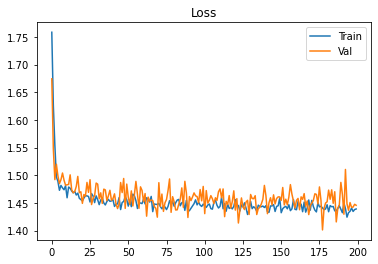

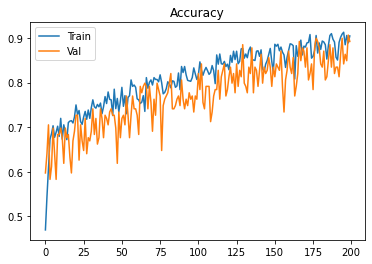

In [12]:
plt.figure(1)
plt.plot(epoch_train_loss)
plt.plot(epoch_val_loss)
plt.title("Loss")
plt.legend(("Train", "Val"))

plt.figure(2)
plt.plot(epoch_train_accuracy)
plt.plot(epoch_val_accuracy)
plt.title("Accuracy")
plt.legend(("Train", "Val"))

In [14]:
max(epoch_val_accuracy)

tensor(0.9065, device='cuda:0')